In [9]:
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)



import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wandb
from modules.utils import load_runs_final_artifact
from modules.models import TCN_channel, TCN, memory_polynomial_channel
from modules.utils import *


DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)

DEVICE cpu


In [10]:
tcn_model = load_runs_final_artifact("giddy-lion-8020", device=DEVICE)
mp_model = memory_polynomial_channel(None, 10, 10, 2, device=DEVICE)


# file_path = "../data/channel_measurements/zarr_files/channel_3e5-8.6MHz_2.7V_scale2_dynamic_power_0.5-3.zarr"
file_path = "../data/channel_measurements/zarr_files/channel_3e5-7.6MHz_2.65.V_0.126A_scale2_dynamic_power_0.5-3.zarr"
ofdm_info = extract_zarr_data(file_path, DEVICE)

Loaded from cache!


In [11]:
X = ofdm_info.sent_frames_time.cpu()
Y = ofdm_info.received_frames_time.cpu()
weights, A, residuals = mp_model.fit(X, Y)

In [12]:
residuals.square().mean().item()

0.004191304557025433

In [13]:
r = mp_model(X) - Y

tensor([[-0.0098, -0.0040, -0.0105,  ..., -0.0040, -0.0140, -0.0046],
        [-0.0835, -0.0829, -0.0394,  ...,  0.0130,  0.0456,  0.0653],
        [-0.0452, -0.0341, -0.0212,  ...,  0.0688,  0.0500,  0.0500],
        ...,
        [-0.0846, -0.1325, -0.1361,  ...,  0.0969,  0.0551,  0.0271],
        [-0.0224, -0.0801, -0.1258,  ...,  0.0264,  0.0796,  0.1046],
        [-0.0623, -0.0731, -0.0793,  ..., -0.0274, -0.0039,  0.0062]])

In [ ]:
# Divide into N power bins and compare NRMSE
N = 10
sent_powers = X.square().mean(dim=-1)
pwr_min = sent_powers.min()
pwr_max = sent_powers.max()
print(f"Minimum AVG power {pwr_min: .3f} | Max AVG power {pwr_max: .3f}")

bins = torch.linspace(pwr_min, pwr_max, N + 1)
bin_ids = torch.bucketize(sent_powers, bins)
binned_losses = torch.zeros(N, 2)
for i in range(N):
    mask = bin_ids == i
    if mask.any():
        filtered_x = X[mask]
        filtered_y = Y[mask]
        noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn_model(filtered_x)
        tcn_rmse_loss = calculate_rmse_pct_loss(filtered_y, y_pred_tcn)
        mp_y_pred = mp_model(filtered_x)
        mp_rmse_loss = calculate_rmse_pct_loss(filtered_y, mp_y_pred)
        binned_losses[i, 0] = tcn_rmse_loss
        binned_losses[i, 1] = mp_rmse_loss
    else:
        binned_losses[i, 0] = torch.nan
        binned_losses[i, 1] = torch.nan

Minimum AVG power  0.060 | Max AVG power  2.097


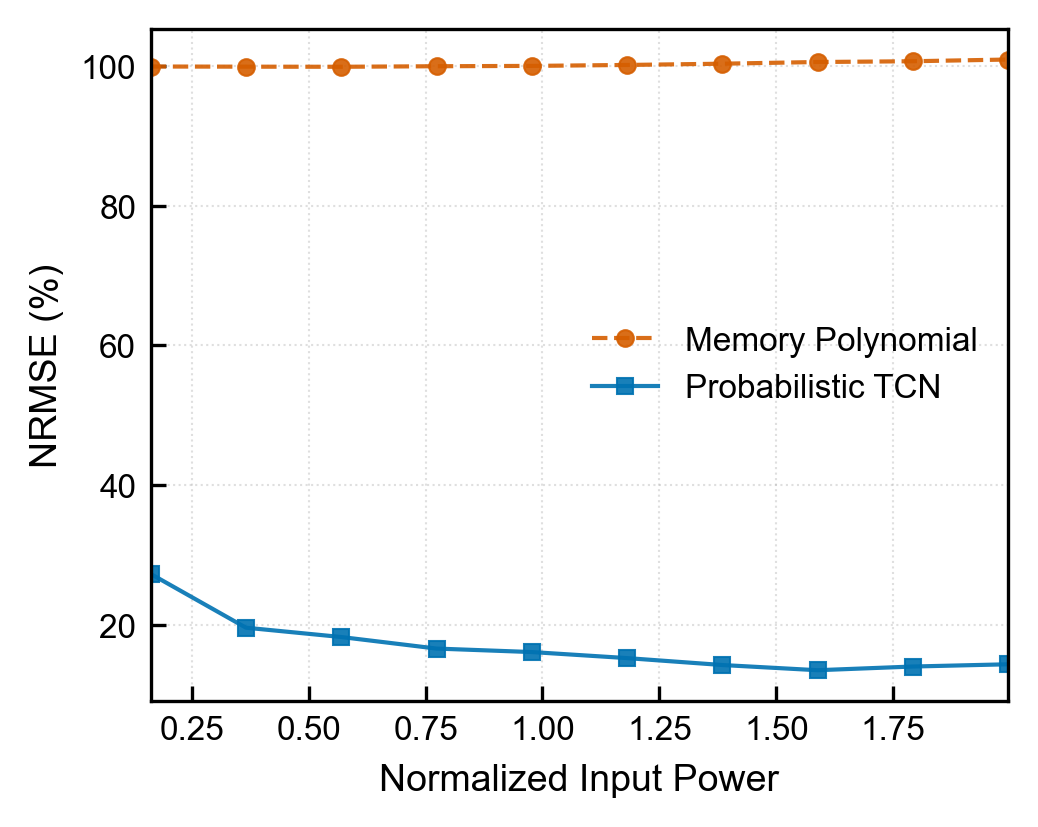

In [8]:

def plot_publication_loss(bins, binned_losses):
    # 1. Calculate Bin Centers for the X-axis
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Convert to numpy for plotting
    x = bin_centers.cpu().numpy()
    y_tcn = binned_losses[:, 0].cpu().numpy()
    y_mp = binned_losses[:, 1].cpu().numpy()

    # 2. Setup "Nature" Style Configuration
    plt.rcParams.update({
        'font.size': 8,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'], # Preferred fonts
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.dpi': 300,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        'xtick.direction': 'in',  # Ticks point inward
        'ytick.direction': 'in',
        'axes.linewidth': 0.8,    # Thinner, cleaner spines
    })

    # 3. Create Figure (Single Column Width: ~3.5 inches)
    fig, ax = plt.subplots(figsize=(3.5, 2.8))

    # 4. Color Palette (Colorblind Friendly)
    # TCN (Ours) = Blue, Baseline = Orange/Red
    c_tcn = '#0072B2'
    c_mp = '#D55E00'

    # 5. Plot Data
    # Baseline: Dashed line to indicate it's the reference
    ax.plot(x, y_mp, color=c_mp, marker='o', linestyle='--',
            label='Memory Polynomial', alpha=0.9, markeredgewidth=0.5)

    # Ours: Solid line to indicate it's the primary contribution
    ax.plot(x, y_tcn, color=c_tcn, marker='s', linestyle='-',
            label='Probabilistic TCN', alpha=0.9, markeredgewidth=0.5)

    # 6. Labels and Limits
    ax.set_xlabel('Normalized Input Power')
    ax.set_ylabel('NRMSE (%)')

    # Clean up limits to fit data tightly but comfortably
    ax.set_xlim(x.min(), x.max())

    # 7. Minimalist Grid & Legend
    ax.grid(True, linestyle=':', alpha=0.4, linewidth=0.5)
    ax.legend(frameon=False, loc='best') # No box around legend looks cleaner

    plt.tight_layout()
    plt.show()

    # Optional: Save as PDF (Vector graphics are required for final submission)
    # fig.savefig("loss_vs_power.pdf", format='pdf', bbox_inches='tight')

# --- Usage with your variables ---
plot_publication_loss(bins, binned_losses)